# Experimento 3 - Comparação com ReAct com Prompt Enriquecido (Factual Direta)

**Objetivo**: Avaliar se a separação explícita da etapa de personalização, proposta no \textit{PersonaReAct}, resulta em respostas mais organizadas, concisas e claras do que a personalização direta por prompt no ReAct tradicional.

**Metodologia**
* Escolher 4 perfis diferentes
* Escolher 1 pergunta para todos os perfis
  * "Qual jogador percorreu mais metros em alta intensidade?"
  * Para cada perfil, responder a pergunta com o ReAct com Prompt Enriquecido e com o PersonaReAct
* Submeter o par de respostas (com ReAct com Prompt Enriquecido e com o PersonaReAct) à LLM avaliadora.

Critérios de avaliação da LLM:
*  Tom Adequado ao Perfil,
*  Quantidade de Informações para o Perfil,
*  Personalização Perceptível.

Cada critério foi aplicado 20 vezes para cada resposta e uma média foi calculada.

# Importação de bibliotecas

In [134]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_rel

# Importação dos Resultados

O arquivo de resultados é composto pelas pontuações (scores) geradas pelo G-Eval para cada um dos 3 critérios elaborados.

A pergunta foi feita utilizando o padrão ReAct e o padrão PersonaReAct para cada perfil listado abaixo.

Cada pontuação foi calculada 20 vezes e os seus resultados salvos nas listas ```scores_personareact``` e ```scores_react_prompt```.

## Torcedor

Pergunta: "Qual jogador mais se destacou em termos de distância percorrida e velocidade média no jogo contra o Ceará no dia 1º de abril de 2023?"

Respostas:
*  **ReAct**: *"No jogo contra o Ceará no dia 1º de abril de 2023, Bruno Pacheco teve uma velocidade média de 1.36 m/s, mostrando sua dedicação e esforço em campo para ajudar o nosso time!"*

*  **PersonaReAct**: *"A velocidade média do Bruno Pacheco no jogo contra o Ceará, realizado no dia 1º de abril de 2023, foi de 1.36 m/s. Esse dado é importante, pois demonstra o empenho e a performance do jogador em campo, refletindo seu envolvimento na partida e como isso pode impactar o desempenho da nossa equipe. Fica a expectativa para ver mais performances como esta nas próximas partidas!"*


In [135]:
# Substitua pelo caminho correto
path_json = "/Users/gustavolgcr/doutorado/implementacoes/experiments/src/results/experiment_3/evaluation_results_with_repetitions_experiment_3_torcedor_factual_direta.json"

with open(path_json, 'r', encoding='utf-8') as f:
    dados = json.load(f)

# Transformar em DataFrame
linhas = []
for item in dados:
    for score_p, score_r in zip(item['scores_personareact'], item['scores_react_prompt']):
        linhas.append({
            "pergunta": item["pergunta"],
            "perfil": item["perfil"],
            "criterio": item["criterio"],
            "score_personareact": score_p,
            "score_react_prompt": score_r,
            "diferenca": score_p - score_r
        })

df = pd.DataFrame(linhas)
df.head()

,pergunta,perfil,criterio,score_personareact,score_react_prompt,diferenca
0,Qual foi a velocidade média do jogador Bruno P...,Torcedor do Time,TomAdequadoAoPerfil,9.05,9.15,-0.10
1,Qual foi a velocidade média do jogador Bruno P...,Torcedor do Time,TomAdequadoAoPerfil,9.07,9.00,0.07
2,Qual foi a velocidade média do jogador Bruno P...,Torcedor do Time,TomAdequadoAoPerfil,9.06,9.08,-0.02
3,Qual foi a velocidade média do jogador Bruno P...,Torcedor do Time,TomAdequadoAoPerfil,9.05,9.10,-0.05
4,Qual foi a velocidade média do jogador Bruno P...,Torcedor do Time,TomAdequadoAoPerfil,9.19,9.17,0.02


In [136]:
agrupado = df.groupby("criterio")[["score_personareact", "score_react_prompt"]].agg(["mean", "std"]).round(2)
agrupado.columns = ['PersonaReAct_Média', 'PersonaReAct_DP', 'ReAct_Média', 'ReAct_DP']
agrupado.reset_index(inplace=True)
agrupado

,criterio,PersonaReAct_Média,PersonaReAct_DP,ReAct_Média,ReAct_DP
0,PersonalizacaoPerceptivel,8.47,0.04,8.62,0.09
1,QuantidadeDeInformacoesParaOPerfil,7.07,0.24,7.84,0.19
2,TomAdequadoAoPerfil,9.16,0.10,9.16,0.10


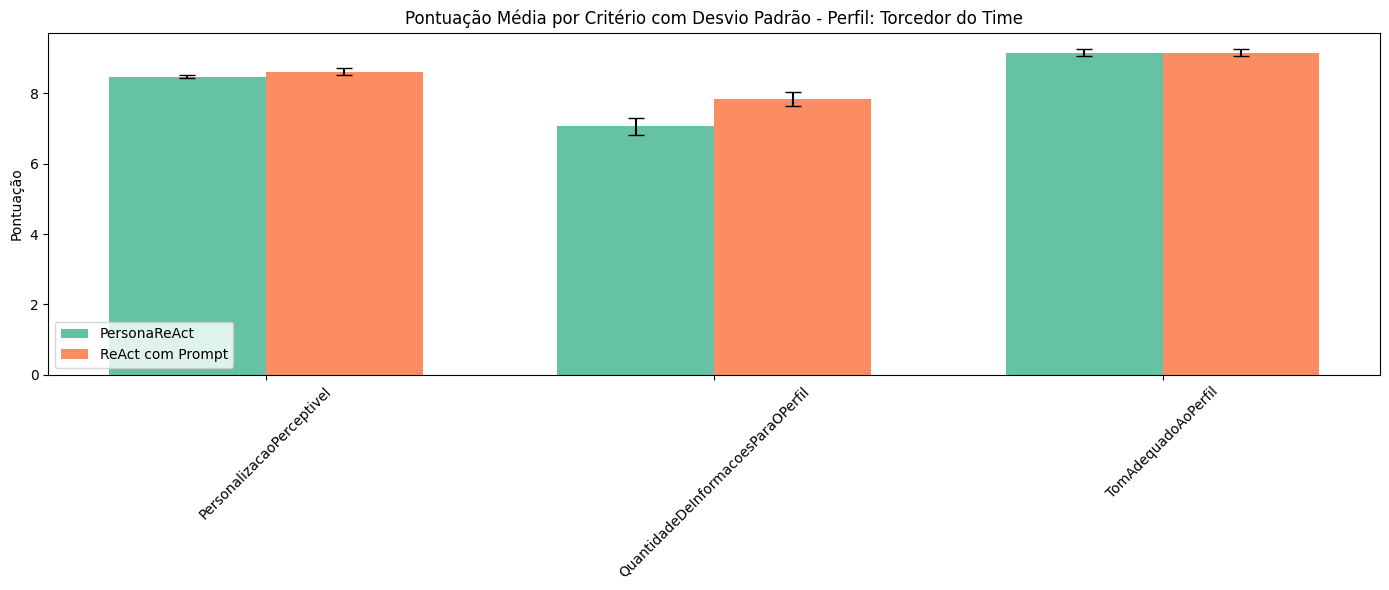

In [137]:
import matplotlib.pyplot as plt
import numpy as np

# Supondo que você tenha um DataFrame chamado df_agg com as colunas:
# ['criterio', 'PersonaReAct_Média', 'PersonaReAct_DP', 'ReAct_Média', 'ReAct_DP']

# Define as posições dos grupos
criterios = agrupado['criterio']
x = np.arange(len(criterios))  # Índices para cada critério

# Define as larguras das barras
largura = 0.35

# Cria a figura
fig, ax = plt.subplots(figsize=(14, 6))

# Barras para PersonaReAct
ax.bar(
    x - largura / 2,
    agrupado['PersonaReAct_Média'],
    width=largura,
    yerr=agrupado['PersonaReAct_DP'],
    capsize=6,
    label='PersonaReAct',
    color="#66c2a5"
)

# Barras para ReAct com Prompt
ax.bar(
    x + largura / 2,
    agrupado['ReAct_Média'],
    width=largura,
    yerr=agrupado['ReAct_DP'],
    capsize=6,
    label='ReAct com Prompt',
    color="#fc8d62"
)

# Ajustes visuais
ax.set_xticks(x)
ax.set_xticklabels(criterios, rotation=45)
ax.set_ylabel("Pontuação")
ax.set_title("Pontuação Média por Critério com Desvio Padrão - Perfil: Torcedor do Time")
ax.legend()
plt.tight_layout()
plt.show()

In [138]:
resultados_teste = []

for criterio in df["criterio"].unique():
    subset = df[df["criterio"] == criterio]
    stat, p = ttest_rel(subset["score_personareact"], subset["score_react_prompt"])
    resultados_teste.append({
        "Critério": criterio,
        "Média PersonaReAct": round(subset["score_personareact"].mean(), 2),
        "Média ReAct": round(subset["score_react_prompt"].mean(), 2),
        "Valor-p": p,
        "Significativo (α=0.05)": "✅" if p < 0.05 else "❌"
    })

pd.DataFrame(resultados_teste)

,Critério,Média PersonaReAct,Média ReAct,Valor-p,Significativo (α=0.05)
0,TomAdequadoAoPerfil,9.16,9.16,8.450026e-01,❌
1,QuantidadeDeInformacoesParaOPerfil,7.07,7.84,4.288289e-08,✅
2,PersonalizacaoPerceptivel,8.47,8.62,7.612523e-07,✅


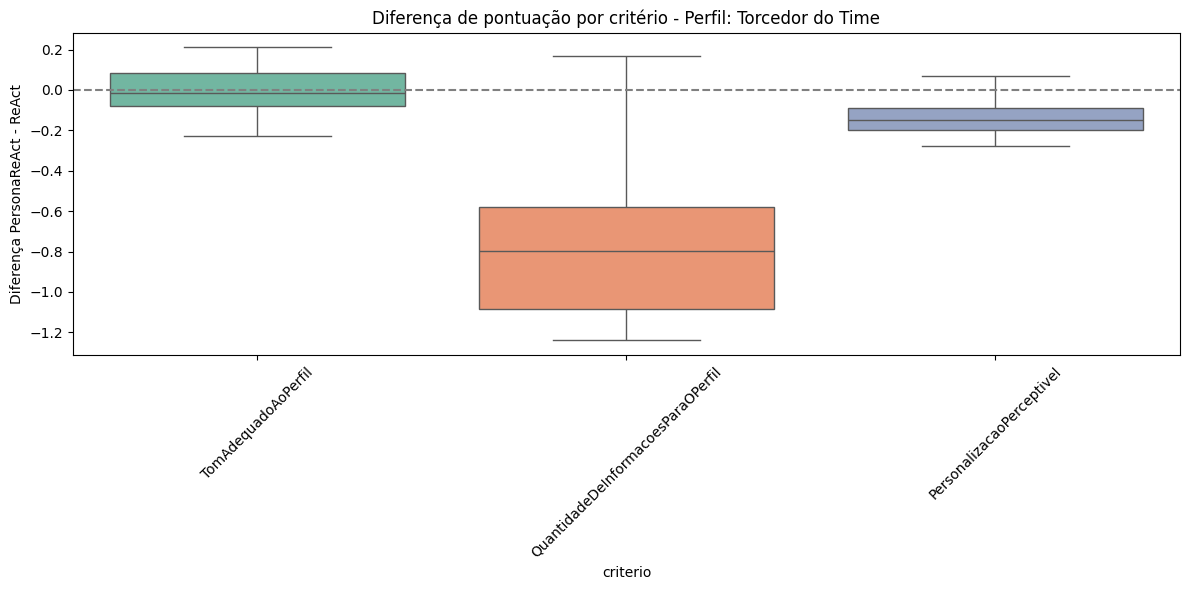

In [139]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x="criterio", y="diferenca", hue="criterio", palette="Set2", legend=False)
plt.axhline(0, color="gray", linestyle="--")
plt.ylabel("Diferença PersonaReAct - ReAct")
plt.title("Diferença de pontuação por critério - Perfil: Torcedor do Time")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

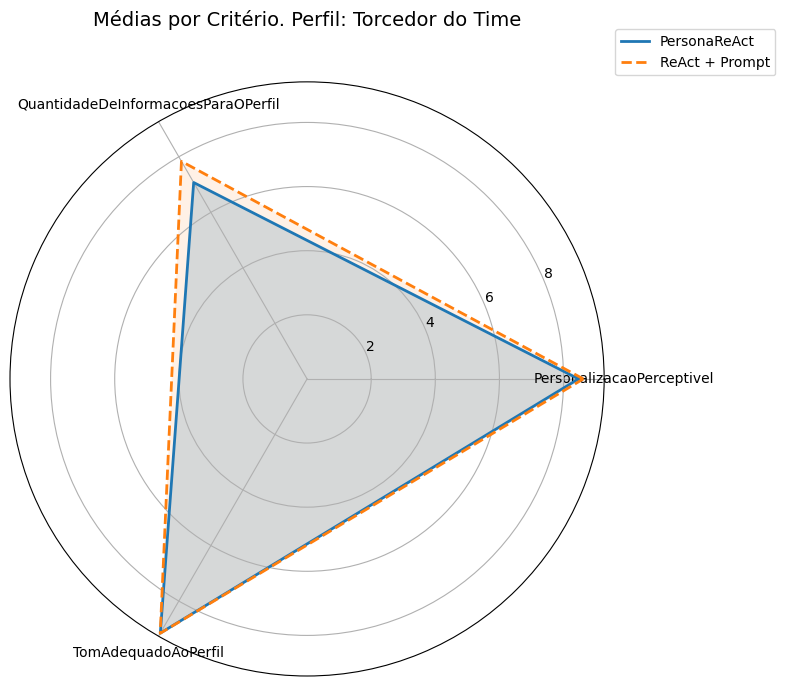

In [140]:
from math import pi
import matplotlib.pyplot as plt

# Calcular médias por critério
media_por_criterio = df.groupby("criterio")[["score_personareact", "score_react_prompt"]].mean().reset_index()

# Preparar dados para o radar chart
categorias = media_por_criterio["criterio"].tolist()
valores_personareact = media_por_criterio["score_personareact"].tolist()
valores_react = media_por_criterio["score_react_prompt"].tolist()

# Fechar o círculo do radar
valores_personareact += [valores_personareact[0]]
valores_react += [valores_react[0]]

# Ângulos do gráfico
num_vars = len(categorias)
angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += [angles[0]]  # Adiciona o primeiro ângulo no final para fechar o círculo

# Criar figura
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

# Plotar os dados
ax.plot(angles, valores_personareact, linewidth=2, linestyle='solid', label='PersonaReAct')
ax.fill(angles, valores_personareact, alpha=0.2)

ax.plot(angles, valores_react, linewidth=2, linestyle='dashed', label='ReAct + Prompt')
ax.fill(angles, valores_react, alpha=0.1)

# Adicionar labels
ax.set_xticks(angles[:-1])  # Remove o ângulo duplicado da label
ax.set_xticklabels(categorias, fontsize=10)
ax.set_title("Médias por Critério. Perfil: Torcedor do Time", size=14, y=1.08)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.tight_layout()
plt.show()

## Comissão Técnica

In [141]:
# Substitua pelo caminho correto
path_json = "/Users/gustavolgcr/doutorado/implementacoes/experiments/src/results/experiment_3/evaluation_results_with_repetitions_experiment_3_comissao_factual_direta.json"

with open(path_json, 'r', encoding='utf-8') as f:
    dados = json.load(f)

# Transformar em DataFrame
linhas = []
for item in dados:
    for score_p, score_r in zip(item['scores_personareact'], item['scores_react_prompt']):
        linhas.append({
            "pergunta": item["pergunta"],
            "perfil": item["perfil"],
            "criterio": item["criterio"],
            "score_personareact": score_p,
            "score_react_prompt": score_r,
            "diferenca": score_p - score_r
        })

df = pd.DataFrame(linhas)
df.head()

,pergunta,perfil,criterio,score_personareact,score_react_prompt,diferenca
0,Qual foi a velocidade média do jogador Bruno P...,Comissão Técnica do Time,TomAdequadoAoPerfil,9.68,9.04,0.64
1,Qual foi a velocidade média do jogador Bruno P...,Comissão Técnica do Time,TomAdequadoAoPerfil,9.71,8.98,0.73
2,Qual foi a velocidade média do jogador Bruno P...,Comissão Técnica do Time,TomAdequadoAoPerfil,9.82,9.02,0.80
3,Qual foi a velocidade média do jogador Bruno P...,Comissão Técnica do Time,TomAdequadoAoPerfil,9.65,8.98,0.67
4,Qual foi a velocidade média do jogador Bruno P...,Comissão Técnica do Time,TomAdequadoAoPerfil,9.68,9.04,0.64


In [142]:
agrupado = df.groupby("criterio")[["score_personareact", "score_react_prompt"]].agg(["mean", "std"]).round(2)
agrupado.columns = ['PersonaReAct_Média', 'PersonaReAct_DP', 'ReAct_Média', 'ReAct_DP']
agrupado.reset_index(inplace=True)
agrupado

,criterio,PersonaReAct_Média,PersonaReAct_DP,ReAct_Média,ReAct_DP
0,PersonalizacaoPerceptivel,9.27,0.09,2.67,0.08
1,QuantidadeDeInformacoesParaOPerfil,9.17,0.04,7.71,0.65
2,TomAdequadoAoPerfil,9.73,0.07,8.95,0.10


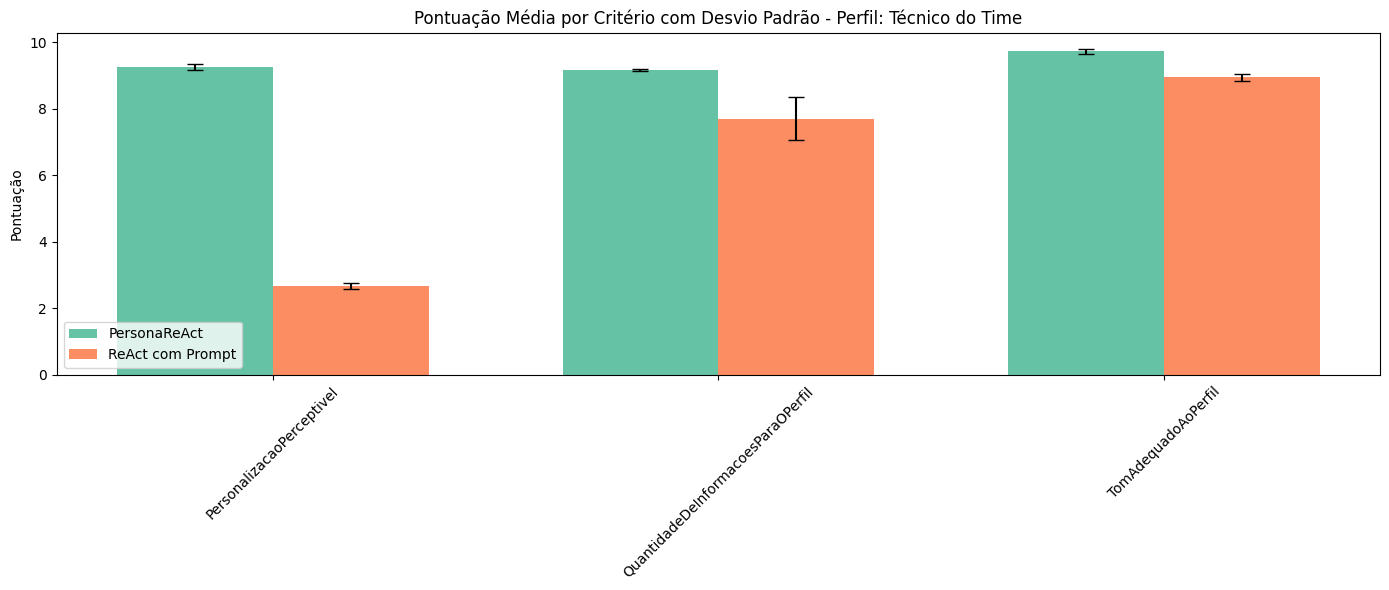

In [143]:
import matplotlib.pyplot as plt
import numpy as np

# Supondo que você tenha um DataFrame chamado df_agg com as colunas:
# ['criterio', 'PersonaReAct_Média', 'PersonaReAct_DP', 'ReAct_Média', 'ReAct_DP']

# Define as posições dos grupos
criterios = agrupado['criterio']
x = np.arange(len(criterios))  # Índices para cada critério

# Define as larguras das barras
largura = 0.35

# Cria a figura
fig, ax = plt.subplots(figsize=(14, 6))

# Barras para PersonaReAct
ax.bar(
    x - largura / 2,
    agrupado['PersonaReAct_Média'],
    width=largura,
    yerr=agrupado['PersonaReAct_DP'],
    capsize=6,
    label='PersonaReAct',
    color="#66c2a5"
)

# Barras para ReAct com Prompt
ax.bar(
    x + largura / 2,
    agrupado['ReAct_Média'],
    width=largura,
    yerr=agrupado['ReAct_DP'],
    capsize=6,
    label='ReAct com Prompt',
    color="#fc8d62"
)

# Ajustes visuais
ax.set_xticks(x)
ax.set_xticklabels(criterios, rotation=45)
ax.set_ylabel("Pontuação")
ax.set_title("Pontuação Média por Critério com Desvio Padrão - Perfil: Técnico do Time")
ax.legend()
plt.tight_layout()
plt.show()

In [144]:
resultados_teste = []

for criterio in df["criterio"].unique():
    subset = df[df["criterio"] == criterio]
    stat, p = ttest_rel(subset["score_personareact"], subset["score_react_prompt"])
    resultados_teste.append({
        "Critério": criterio,
        "Média PersonaReAct": round(subset["score_personareact"].mean(), 2),
        "Média ReAct": round(subset["score_react_prompt"].mean(), 2),
        "Valor-p": p,
        "Significativo (α=0.05)": "✅" if p < 0.05 else "❌"
    })

pd.DataFrame(resultados_teste)

,Critério,Média PersonaReAct,Média ReAct,Valor-p,Significativo (α=0.05)
0,TomAdequadoAoPerfil,9.73,8.95,3.555553e-16,✅
1,QuantidadeDeInformacoesParaOPerfil,9.17,7.71,6.142392e-09,✅
2,PersonalizacaoPerceptivel,9.27,2.67,6.039424e-34,✅


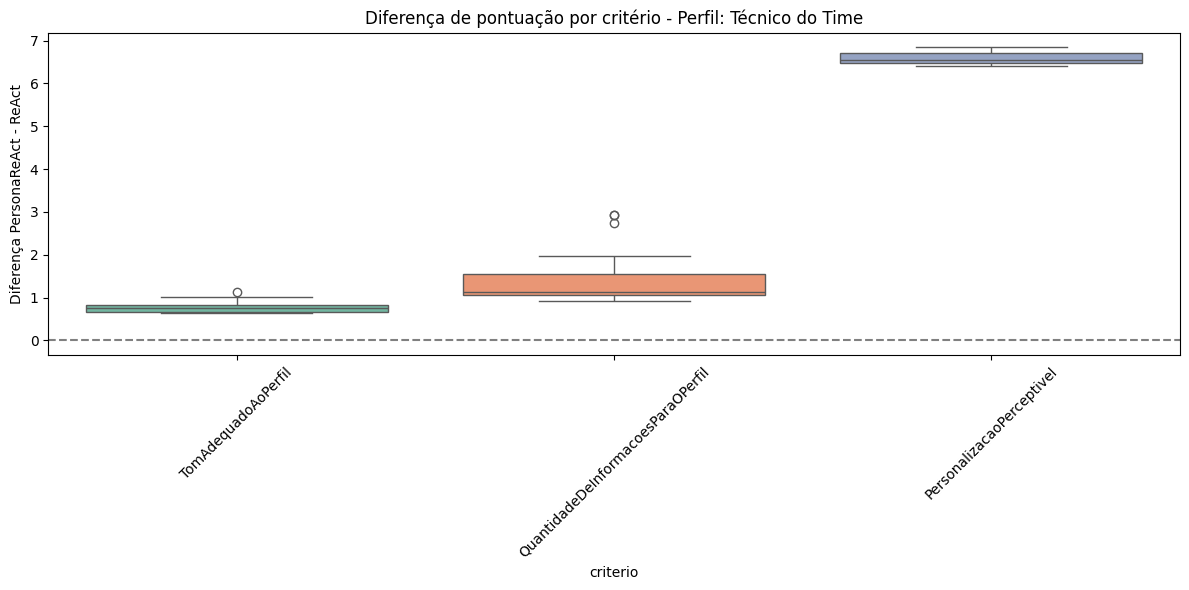

In [145]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x="criterio", y="diferenca", hue="criterio", palette="Set2", legend=False)
plt.axhline(0, color="gray", linestyle="--")
plt.ylabel("Diferença PersonaReAct - ReAct")
plt.title("Diferença de pontuação por critério - Perfil: Técnico do Time")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

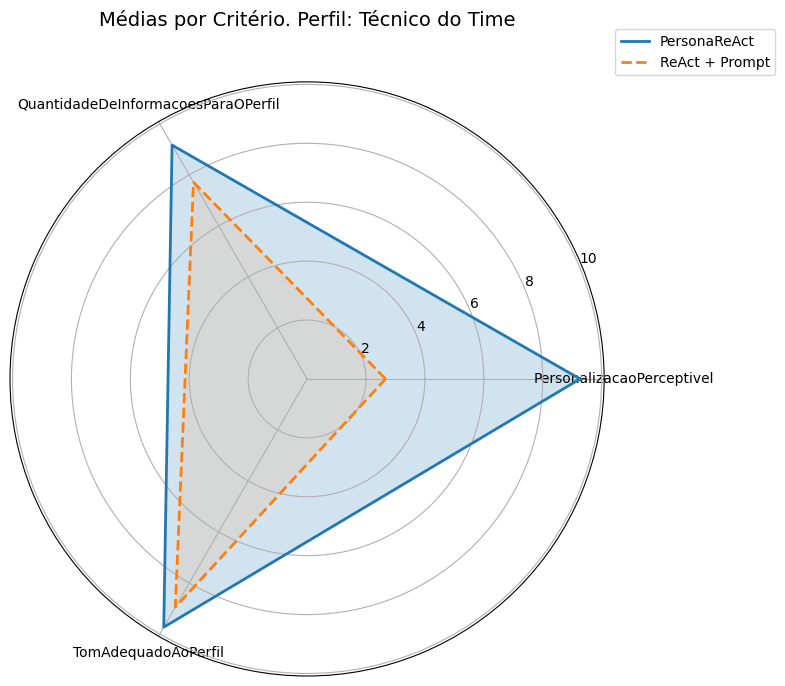

In [146]:
from math import pi
import matplotlib.pyplot as plt

# Calcular médias por critério
media_por_criterio = df.groupby("criterio")[["score_personareact", "score_react_prompt"]].mean().reset_index()

# Preparar dados para o radar chart
categorias = media_por_criterio["criterio"].tolist()
valores_personareact = media_por_criterio["score_personareact"].tolist()
valores_react = media_por_criterio["score_react_prompt"].tolist()

# Fechar o círculo do radar
valores_personareact += [valores_personareact[0]]
valores_react += [valores_react[0]]

# Ângulos do gráfico
num_vars = len(categorias)
angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += [angles[0]]  # Adiciona o primeiro ângulo no final para fechar o círculo

# Criar figura
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

# Plotar os dados
ax.plot(angles, valores_personareact, linewidth=2, linestyle='solid', label='PersonaReAct')
ax.fill(angles, valores_personareact, alpha=0.2)

ax.plot(angles, valores_react, linewidth=2, linestyle='dashed', label='ReAct + Prompt')
ax.fill(angles, valores_react, alpha=0.1)

# Adicionar labels
ax.set_xticks(angles[:-1])  # Remove o ângulo duplicado da label
ax.set_xticklabels(categorias, fontsize=10)
ax.set_title("Médias por Critério. Perfil: Técnico do Time", size=14, y=1.08)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.tight_layout()
plt.show()

## Jornalista Esportivo

In [147]:
# Substitua pelo caminho correto
path_json = "/Users/gustavolgcr/doutorado/implementacoes/experiments/src/results/experiment_3/evaluation_results_with_repetitions_experiment_3_jornalista_factual_direta.json"

with open(path_json, 'r', encoding='utf-8') as f:
    dados = json.load(f)

# Transformar em DataFrame
linhas = []
for item in dados:
    for score_p, score_r in zip(item['scores_personareact'], item['scores_react_prompt']):
        linhas.append({
            "pergunta": item["pergunta"],
            "perfil": item["perfil"],
            "criterio": item["criterio"],
            "score_personareact": score_p,
            "score_react_prompt": score_r,
            "diferenca": score_p - score_r
        })

df = pd.DataFrame(linhas)
df.head()

,pergunta,perfil,criterio,score_personareact,score_react_prompt,diferenca
0,Qual foi a velocidade média do jogador Bruno P...,Jornalista Esportivo,TomAdequadoAoPerfil,9.27,8.95,0.32
1,Qual foi a velocidade média do jogador Bruno P...,Jornalista Esportivo,TomAdequadoAoPerfil,9.35,8.99,0.36
2,Qual foi a velocidade média do jogador Bruno P...,Jornalista Esportivo,TomAdequadoAoPerfil,9.30,8.94,0.36
3,Qual foi a velocidade média do jogador Bruno P...,Jornalista Esportivo,TomAdequadoAoPerfil,9.27,9.10,0.17
4,Qual foi a velocidade média do jogador Bruno P...,Jornalista Esportivo,TomAdequadoAoPerfil,9.44,9.01,0.43


In [148]:
agrupado = df.groupby("criterio")[["score_personareact", "score_react_prompt"]].agg(["mean", "std"]).round(2)
agrupado.columns = ['PersonaReAct_Média', 'PersonaReAct_DP', 'ReAct_Média', 'ReAct_DP']
agrupado.reset_index(inplace=True)
agrupado

,criterio,PersonaReAct_Média,PersonaReAct_DP,ReAct_Média,ReAct_DP
0,PersonalizacaoPerceptivel,9.12,0.04,8.75,0.06
1,QuantidadeDeInformacoesParaOPerfil,9.51,0.15,9.49,0.11
2,TomAdequadoAoPerfil,9.32,0.08,9.01,0.09


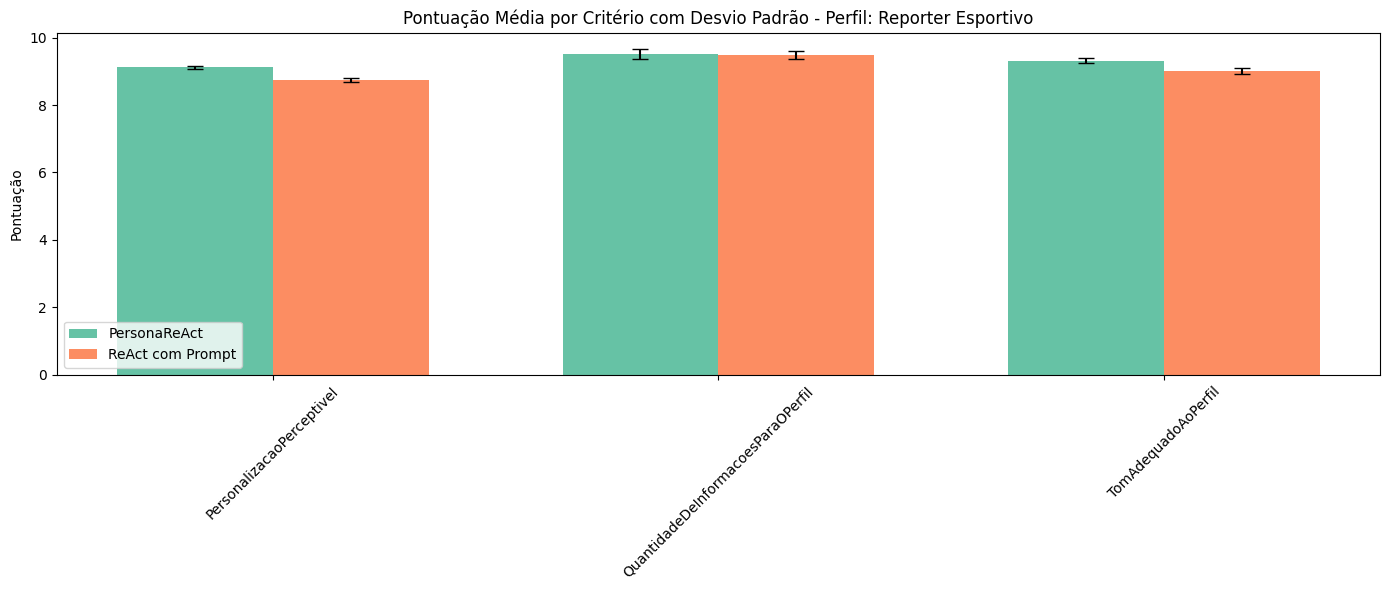

In [149]:
import matplotlib.pyplot as plt
import numpy as np

# Supondo que você tenha um DataFrame chamado df_agg com as colunas:
# ['criterio', 'PersonaReAct_Média', 'PersonaReAct_DP', 'ReAct_Média', 'ReAct_DP']

# Define as posições dos grupos
criterios = agrupado['criterio']
x = np.arange(len(criterios))  # Índices para cada critério

# Define as larguras das barras
largura = 0.35

# Cria a figura
fig, ax = plt.subplots(figsize=(14, 6))

# Barras para PersonaReAct
ax.bar(
    x - largura / 2,
    agrupado['PersonaReAct_Média'],
    width=largura,
    yerr=agrupado['PersonaReAct_DP'],
    capsize=6,
    label='PersonaReAct',
    color="#66c2a5"
)

# Barras para ReAct com Prompt
ax.bar(
    x + largura / 2,
    agrupado['ReAct_Média'],
    width=largura,
    yerr=agrupado['ReAct_DP'],
    capsize=6,
    label='ReAct com Prompt',
    color="#fc8d62"
)

# Ajustes visuais
ax.set_xticks(x)
ax.set_xticklabels(criterios, rotation=45)
ax.set_ylabel("Pontuação")
ax.set_title("Pontuação Média por Critério com Desvio Padrão - Perfil: Reporter Esportivo")
ax.legend()
plt.tight_layout()
plt.show()

In [150]:
resultados_teste = []

for criterio in df["criterio"].unique():
    subset = df[df["criterio"] == criterio]
    stat, p = ttest_rel(subset["score_personareact"], subset["score_react_prompt"])
    resultados_teste.append({
        "Critério": criterio,
        "Média PersonaReAct": round(subset["score_personareact"].mean(), 2),
        "Média ReAct": round(subset["score_react_prompt"].mean(), 2),
        "Valor-p": p,
        "Significativo (α=0.05)": "✅" if p < 0.05 else "❌"
    })

pd.DataFrame(resultados_teste)

,Critério,Média PersonaReAct,Média ReAct,Valor-p,Significativo (α=0.05)
0,TomAdequadoAoPerfil,9.32,9.01,5.265764e-10,✅
1,QuantidadeDeInformacoesParaOPerfil,9.51,9.49,6.347865e-01,❌
2,PersonalizacaoPerceptivel,9.12,8.75,1.094201e-14,✅


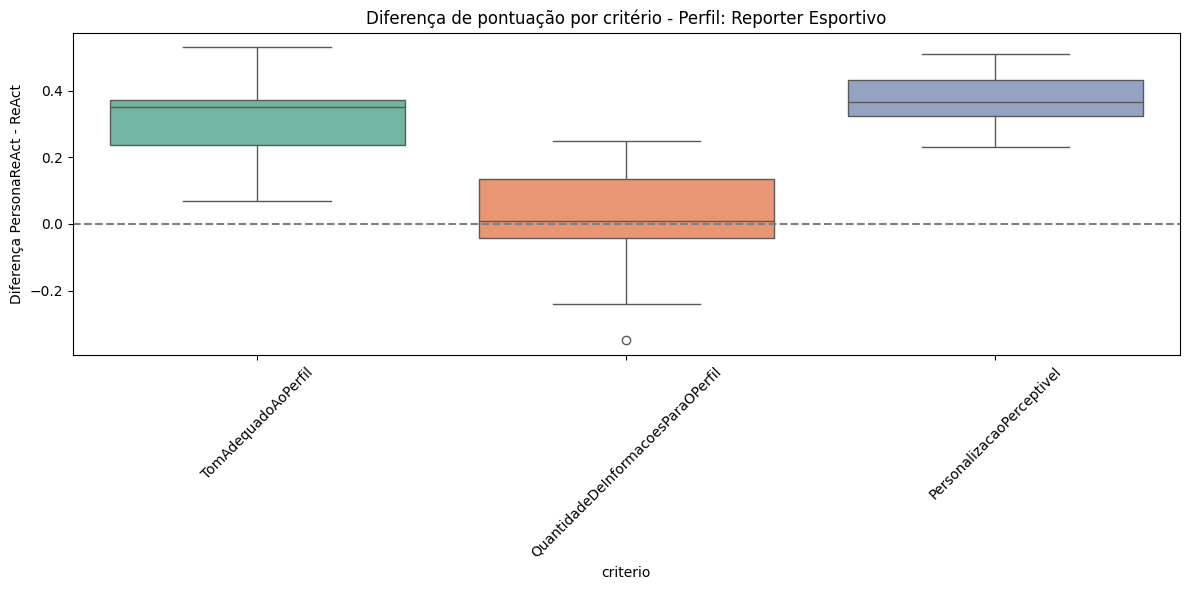

In [151]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x="criterio", y="diferenca", hue="criterio", palette="Set2", legend=False)
plt.axhline(0, color="gray", linestyle="--")
plt.ylabel("Diferença PersonaReAct - ReAct")
plt.title("Diferença de pontuação por critério - Perfil: Reporter Esportivo")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

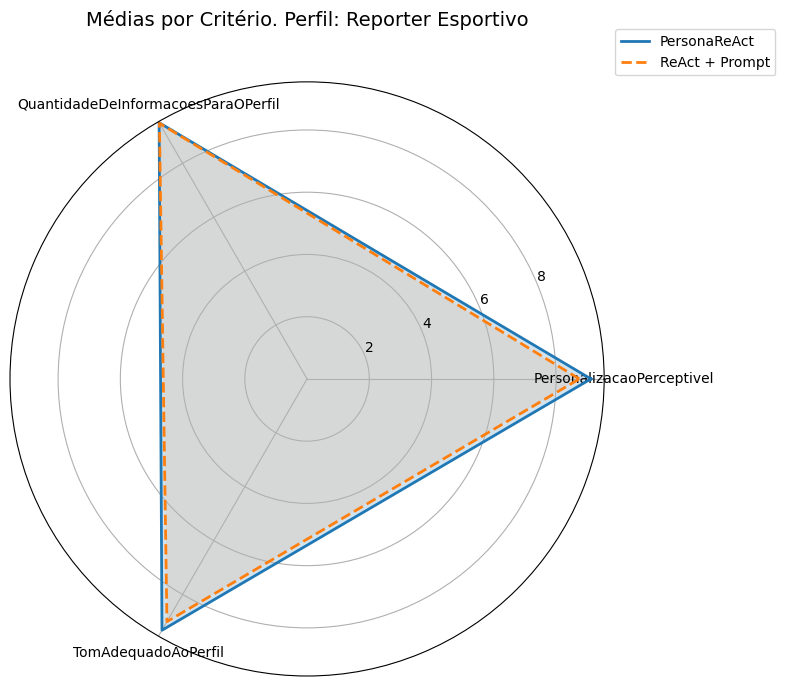

In [152]:
from math import pi
import matplotlib.pyplot as plt

# Calcular médias por critério
media_por_criterio = df.groupby("criterio")[["score_personareact", "score_react_prompt"]].mean().reset_index()

# Preparar dados para o radar chart
categorias = media_por_criterio["criterio"].tolist()
valores_personareact = media_por_criterio["score_personareact"].tolist()
valores_react = media_por_criterio["score_react_prompt"].tolist()

# Fechar o círculo do radar
valores_personareact += [valores_personareact[0]]
valores_react += [valores_react[0]]

# Ângulos do gráfico
num_vars = len(categorias)
angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += [angles[0]]  # Adiciona o primeiro ângulo no final para fechar o círculo

# Criar figura
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

# Plotar os dados
ax.plot(angles, valores_personareact, linewidth=2, linestyle='solid', label='PersonaReAct')
ax.fill(angles, valores_personareact, alpha=0.2)

ax.plot(angles, valores_react, linewidth=2, linestyle='dashed', label='ReAct + Prompt')
ax.fill(angles, valores_react, alpha=0.1)

# Adicionar labels
ax.set_xticks(angles[:-1])  # Remove o ângulo duplicado da label
ax.set_xticklabels(categorias, fontsize=10)
ax.set_title("Médias por Critério. Perfil: Reporter Esportivo", size=14, y=1.08)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.tight_layout()
plt.show()

## Árbitro do Jogo

In [153]:
# Substitua pelo caminho correto
path_json = "/Users/gustavolgcr/doutorado/implementacoes/experiments/src/results/experiment_3/evaluation_results_with_repetitions_experiment_3_arbitro_factual_direta.json"

with open(path_json, 'r', encoding='utf-8') as f:
    dados = json.load(f)

# Transformar em DataFrame
linhas = []
for item in dados:
    for score_p, score_r in zip(item['scores_personareact'], item['scores_react_prompt']):
        linhas.append({
            "pergunta": item["pergunta"],
            "perfil": item["perfil"],
            "criterio": item["criterio"],
            "score_personareact": score_p,
            "score_react_prompt": score_r,
            "diferenca": score_p - score_r
        })

df = pd.DataFrame(linhas)
df.head()

,pergunta,perfil,criterio,score_personareact,score_react_prompt,diferenca
0,Qual foi a velocidade média do jogador Bruno P...,Árbitro do Jogo,TomAdequadoAoPerfil,7.34,7.84,-0.50
1,Qual foi a velocidade média do jogador Bruno P...,Árbitro do Jogo,TomAdequadoAoPerfil,7.36,7.76,-0.40
2,Qual foi a velocidade média do jogador Bruno P...,Árbitro do Jogo,TomAdequadoAoPerfil,7.34,7.02,0.32
3,Qual foi a velocidade média do jogador Bruno P...,Árbitro do Jogo,TomAdequadoAoPerfil,6.71,7.97,-1.26
4,Qual foi a velocidade média do jogador Bruno P...,Árbitro do Jogo,TomAdequadoAoPerfil,7.40,7.61,-0.21


In [154]:
agrupado = df.groupby("criterio")[["score_personareact", "score_react_prompt"]].agg(["mean", "std"]).round(2)
agrupado.columns = ['PersonaReAct_Média', 'PersonaReAct_DP', 'ReAct_Média', 'ReAct_DP']
agrupado.reset_index(inplace=True)
agrupado

,criterio,PersonaReAct_Média,PersonaReAct_DP,ReAct_Média,ReAct_DP
0,PersonalizacaoPerceptivel,7.07,0.38,6.08,0.67
1,QuantidadeDeInformacoesParaOPerfil,8.99,0.09,9.03,0.10
2,TomAdequadoAoPerfil,7.17,0.32,7.61,0.35


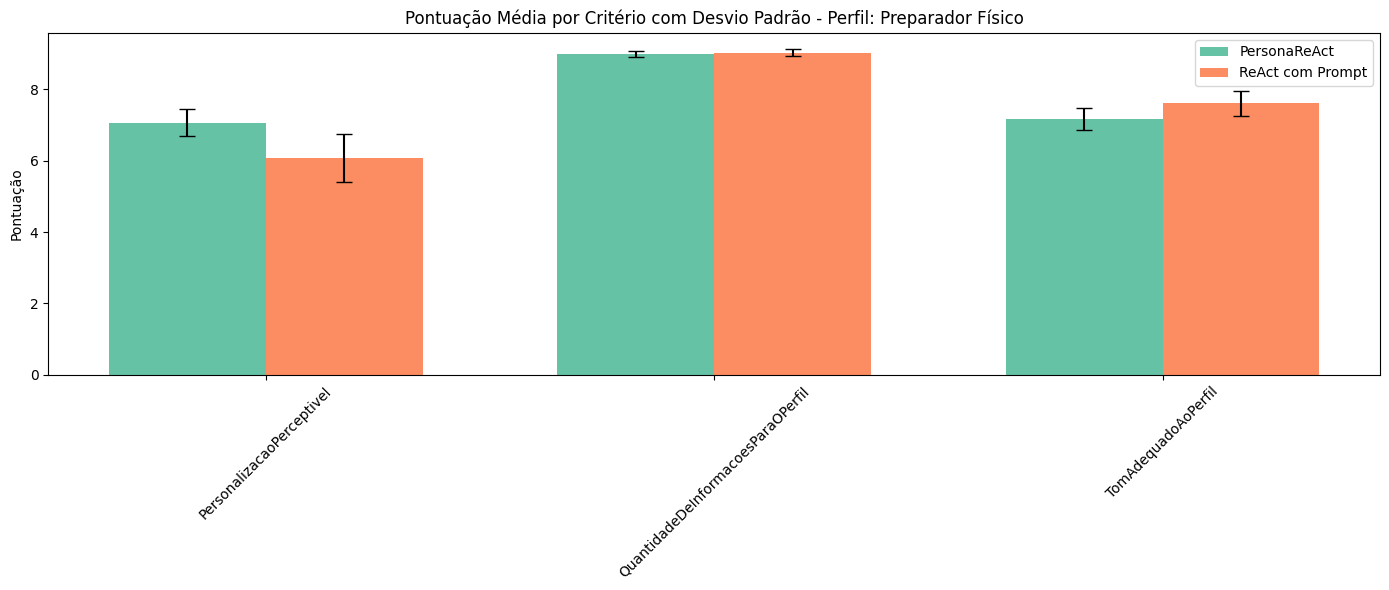

In [155]:
import matplotlib.pyplot as plt
import numpy as np

# Supondo que você tenha um DataFrame chamado df_agg com as colunas:
# ['criterio', 'PersonaReAct_Média', 'PersonaReAct_DP', 'ReAct_Média', 'ReAct_DP']

# Define as posições dos grupos
criterios = agrupado['criterio']
x = np.arange(len(criterios))  # Índices para cada critério

# Define as larguras das barras
largura = 0.35

# Cria a figura
fig, ax = plt.subplots(figsize=(14, 6))

# Barras para PersonaReAct
ax.bar(
    x - largura / 2,
    agrupado['PersonaReAct_Média'],
    width=largura,
    yerr=agrupado['PersonaReAct_DP'],
    capsize=6,
    label='PersonaReAct',
    color="#66c2a5"
)

# Barras para ReAct com Prompt
ax.bar(
    x + largura / 2,
    agrupado['ReAct_Média'],
    width=largura,
    yerr=agrupado['ReAct_DP'],
    capsize=6,
    label='ReAct com Prompt',
    color="#fc8d62"
)

# Ajustes visuais
ax.set_xticks(x)
ax.set_xticklabels(criterios, rotation=45)
ax.set_ylabel("Pontuação")
ax.set_title("Pontuação Média por Critério com Desvio Padrão - Perfil: Preparador Físico")
ax.legend()
plt.tight_layout()
plt.show()

In [156]:
resultados_teste = []

for criterio in df["criterio"].unique():
    subset = df[df["criterio"] == criterio]
    stat, p = ttest_rel(subset["score_personareact"], subset["score_react_prompt"])
    resultados_teste.append({
        "Critério": criterio,
        "Média PersonaReAct": round(subset["score_personareact"].mean(), 2),
        "Média ReAct": round(subset["score_react_prompt"].mean(), 2),
        "Valor-p": p,
        "Significativo (α=0.05)": "✅" if p < 0.05 else "❌"
    })

pd.DataFrame(resultados_teste)

,Critério,Média PersonaReAct,Média ReAct,Valor-p,Significativo (α=0.05)
0,TomAdequadoAoPerfil,7.17,7.61,0.001134,✅
1,QuantidadeDeInformacoesParaOPerfil,8.99,9.03,0.226401,❌
2,PersonalizacaoPerceptivel,7.07,6.08,0.000017,✅


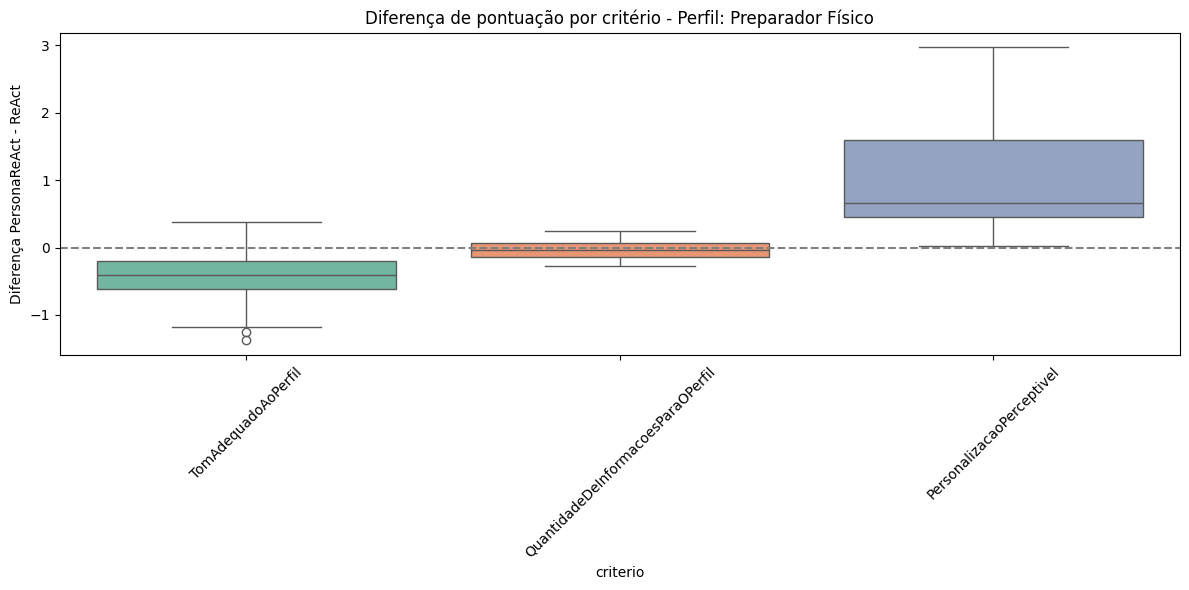

In [157]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x="criterio", y="diferenca", hue="criterio", palette="Set2", legend=False)
plt.axhline(0, color="gray", linestyle="--")
plt.ylabel("Diferença PersonaReAct - ReAct")
plt.title("Diferença de pontuação por critério - Perfil: Preparador Físico")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

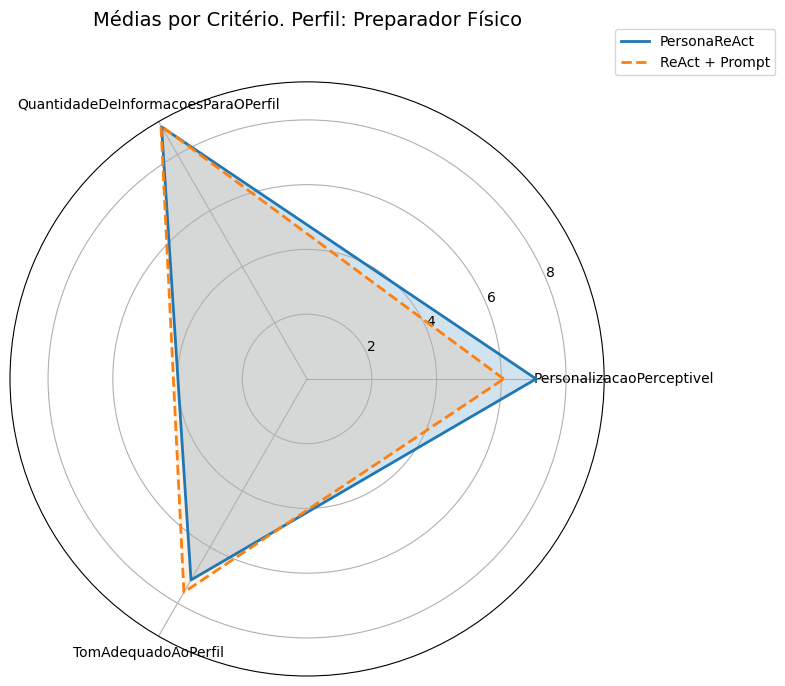

In [158]:
from math import pi
import matplotlib.pyplot as plt

# Calcular médias por critério
media_por_criterio = df.groupby("criterio")[["score_personareact", "score_react_prompt"]].mean().reset_index()

# Preparar dados para o radar chart
categorias = media_por_criterio["criterio"].tolist()
valores_personareact = media_por_criterio["score_personareact"].tolist()
valores_react = media_por_criterio["score_react_prompt"].tolist()

# Fechar o círculo do radar
valores_personareact += [valores_personareact[0]]
valores_react += [valores_react[0]]

# Ângulos do gráfico
num_vars = len(categorias)
angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += [angles[0]]  # Adiciona o primeiro ângulo no final para fechar o círculo

# Criar figura
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

# Plotar os dados
ax.plot(angles, valores_personareact, linewidth=2, linestyle='solid', label='PersonaReAct')
ax.fill(angles, valores_personareact, alpha=0.2)

ax.plot(angles, valores_react, linewidth=2, linestyle='dashed', label='ReAct + Prompt')
ax.fill(angles, valores_react, alpha=0.1)

# Adicionar labels
ax.set_xticks(angles[:-1])  # Remove o ângulo duplicado da label
ax.set_xticklabels(categorias, fontsize=10)
ax.set_title("Médias por Critério. Perfil: Preparador Físico", size=14, y=1.08)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.tight_layout()
plt.show()